# Neighbors, Clusters, Classification

By [Allison Parrish](http://www.decontextualize.com/)

(Note: Rough draft! Notes incomplete.)

In this notebook, I'm going to take you through a couple of simple, well-known techniques for exploring small sequences of text (like lines of poetry or sentences). These techniques include:

* Making vectors for text sequences
* Nearest-neighbor lookups for semantic similarity
* Visualizing corpora with t-SNE
* Clustering sentence vectors to discover similar items
* Classification with vectors

We're going to work with a corpus of several million lines of poetry, scraped from Project Gutenberg. Before you continue, download the file by executing the cell below:

In [ ]:
!curl -L -O http://static.decontextualize.com/gutenberg-poetry-v001.ndjson.gz

I'm going to use [spaCy](http://spacy.io/) extensively, both as a way to parse text into sentences and also as a source for pre-trained word vectors. Make sure you have it installed, along with the `en_core_web_md` or `en_core_web_lg` models. This notebook also assumes that you have [scikit-learn](https://scikit-learn.org/stable/), [numpy](https://numpy.org/) and [simpleneighbors](https://github.com/aparrish/simpleneighbors) installed.

## Sentence vectors

[Review the concept of word vectors](https://github.com/aparrish/rwet/blob/master/understanding-word-vectors.ipynb) before continuing.

Word vectors work great when we're interested in individual words. More often, though, we're interested in longer stretches of text, like sentences, lines, paragraphs. If we had a way to represent these longer stretches of text as vectors, we could perform all of the same operations on them that word vectors allow us to perform on words. But how to represent stretches of text as sequences?

There are lots of different ways! The classic technique in machine learning is to use the frequency of terms found in each sequence (methods like [tfidf](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/)), or similar techniques like [doc2vec](https://rare-technologies.com/doc2vec-tutorial/). Another way is to train a recurrent neural network (like an LSTM) and use its hidden state. Another is to use a pre-trained model, like Google's [Universal Sentence Encoder](https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html).

But a surprisingly effective technique is to simply average together the word vectors for each word in the sentence. A big advantage of this technique is that *no further training is needed*, beyond the training needed to calculate the word vectors; if you're using pre-trained vectors, even that step can be skipped. You won't get state-of-the-art results on NLP benchmarks with this technique, but it's a good baseline and still useful for many tasks.

In the section below, I sample ten thousand lines of poetry from a Project Gutenberg poetry corpus and assign each a vector using this averaging technique.

In [1]:
import numpy as np
import spacy

In [2]:
import gzip, json, random

Load spacy's language model:

In [3]:
nlp = spacy.load('en_core_web_md')

And then load up all of the lines of poetry:

In [4]:
lines = []
for line in gzip.open("./gutenberg-poetry-v001.ndjson.gz"):
    data = json.loads(line)
    lines.append(data['s'])

In [5]:
len(lines)

3085117

To make things a bit faster and less memory-intensive, I'm only going to use ten thousand lines of poetry, sampled randomly. (You can change this number to something bigger if you want! But note that some of the stuff we're doing later on in the notebook will take longer.)

In [7]:
sampled_lines = random.sample(lines, 10000)

### Averages and weighted averages

I'm going to experiment with two techniques for producing sentence vectors here. The first (`summary_average()`) uses spaCy's `.vector` attribute on a parsed document to produce the vector. (The default way to calculate a vector for any unit larger than a token in spaCy is to average the vectors of the words comprising the unit together, as explained above.) The second technique (`summary_inv_freq()`) *weights* each word's contribution to the average based on the inverse of its frequency (according to spaCy's built-in word frequency information). The intention of weighting by inverse frequency is to reduce the contribution of common function words like "the" and "of" to the sentence vector. (This approach was inspired by [Arora et al.'s Smooth Inverse Frequency technique](https://github.com/PrincetonML/SIF), though my approach doesn't remove the principle component.)

In [8]:
def summary_average(sent):
    return nlp(sent, disable=['parser', 'tagger', 'ner']).vector

In [9]:
def summary_inv_freq(sent, a=0.001):
    s = nlp(sent, disable=['parser', 'tagger', 'ner'])
    weights = [a / (a + np.exp(tok.prob)) for tok in s]
    emb = np.average([tok.vector for tok in s], axis=0, weights=weights)
    return emb

The code in the cell below computes the embeddings for the sampled lines of poetry with both techniques:

In [10]:
avg_embeddings = [summary_average(line) for line in sampled_lines]
inv_embeddings = [summary_inv_freq(line) for line in sampled_lines]

And here's what they look like:

In [12]:
rand_idx = random.randrange(len(sampled_lines))
sampled_lines[rand_idx], avg_embeddings[rand_idx], inv_embeddings[rand_idx]

('lest the storm-winds catch me again and bear me over the',
 array([ 2.69354181e-03,  9.07204524e-02, -1.71728373e-01,  2.42113844e-02,
         6.42939955e-02, -4.80807424e-02, -9.39700976e-02,  1.49552390e-01,
        -8.44671428e-02,  2.29439306e+00, -1.31036311e-01, -5.74624464e-02,
         1.63799543e-02, -2.54260778e-01, -1.82022467e-01,  5.17399162e-02,
        -3.90093662e-02,  8.07732701e-01, -3.39061543e-02, -3.06326132e-02,
         8.51901397e-02, -5.43376952e-02, -1.47642314e-01,  5.68738915e-02,
        -2.52513848e-02, -4.91692219e-03, -5.91476969e-02, -4.76820283e-02,
        -8.38894106e-04, -1.23191312e-01, -1.29851580e-01,  2.19283640e-01,
        -3.09225023e-01,  1.69975422e-02,  1.26314774e-01, -3.28138471e-02,
         4.48207464e-03,  3.66889797e-02,  3.35833356e-02,  3.48269427e-03,
        -8.65271389e-02, -4.27337699e-02, -7.42269754e-02, -8.68002847e-02,
         1.43338293e-01,  4.21460047e-02, -1.56838447e-01, -8.57737139e-02,
        -5.42704612e-02,  6

## Build your own little search engine

Sentence vectors aren't especially interesting on their own! One thing we can use them for is to build a tiny "search engine" based on semantic similarity between lines. To do this, we need to be able to calculate the distance between a target sentence's vector (not necessarily a sentence from our corpus) and vectors of the sentences in the corpus, returning them ranked based on the distance between the two vectors. However, doing this comparison is computationally expensive and potentially very slow. Instead, we'll use an *approximate* nearest neighbors algorithm, which uses some tricks to make the computation faster, at the cost of a little bit of accuracy. I'm going to use the Simple Neighbors package as a way to build an approximate nearest neighbors index quickly and easily.

In [13]:
from simpleneighbors import SimpleNeighbors

First, I build an approximate nearest neighbors index using the vectors I got from the inverse frequency weighting technique:

In [15]:
inv_nn = SimpleNeighbors(300)
for vec, line in zip(inv_embeddings, sampled_lines):
    inv_nn.add_one(line, vec)
inv_nn.build()

The `.nearest()` method returns the sentences from the corpus whose vectors are closest to the vector you pass in. The code in the cell below uses the `summary_inv_freq()` function to return the sentences most similar to the sentence you type in. The number controls how many sentences should be returned.

In [18]:
inv_nn.nearest(summary_inv_freq("I don't want the words, I want the sound"), 5)

['You first did hear my love speak plain;',
 'We did not speak one word,',
 'That I am here to listen while you say it.',
 "With my weak voice I'll sing, or say",
 "So long as it ends with the sound an' song of a kiss,"]

To get neighbors for a random item in the corpus:

In [13]:
inv_nn.neighbors(random.choice(inv_nn.corpus))

['The Tonne stod, and what it was.',
 'And axeth of hem hou it stod;',
 'To a lorde þat hade a uyne I wate,',
 'Ish only heardt far ober het',
 'Mi world stod on an other whiel',
 "En if she had neber lef' me",
 '“Ffurth he stalkis a stye, by tha stille euys,',
 'per me videre quomodo istae duae fictiones habeant inter se',
 'Da puer plectrum, choreis ut canam fidelibus',
 'si framden starkiu wunder   sit in Etzelen lant.',
 'Han le fere, e git augelli, ognun talora',
 'Yn y terau tormeu tir.”']

Now, let's build an index using the non-weighted average:

In [19]:
avg_nn = SimpleNeighbors(300)
for vec, line in zip(avg_embeddings, sampled_lines):
    avg_nn.add_one(line, vec)
avg_nn.build()

In [20]:
avg_nn.nearest(summary_average("I don't want the words, I want the sound"), 5)

['I might not tell everybody, but I will tell you.',
 'How I know not; but this I know indeed,',
 'To one such I would say,',
 "Of course it may seem mean but I'm going to keep them clean--",
 'What have they done to me, that I am naked?']

And again, finding neighbors to a randomly selected item:

In [21]:
avg_nn.neighbors(random.choice(avg_nn.corpus))

['Through the stones?',
 "That cheer'd the heart or charm'd the eye?",
 'Even to the seal set on the unopening tomb?',
 'The men before the Flood?',
 'On the Piccadilly pavement, of the myriad eyes that seem',
 'From breaking through the clouds with hideous clap?',
 'Till at length they came bump on the rocks and the shallows',
 'Down out of Heaven through the sleepless nights,--',
 'Home through the darkness to the evening fire.',
 'Though the succeeding wave washes it out from the sand.',
 "Passing in peace the tomb around, and o'er the altars rolled:",
 'the first, through the blue chamber to the purple&mdash;through']

### Comparing techniques

I feel like the weighted average technique yields results that feel more semantically similar, but the non-weighted average gives sentences that have some syntactic similarity as well. Let's compare the two techniques in an informal, qualitative manner. Pick a random line:

In [36]:
picked = random.choice(sampled_lines)
print(picked)

You purred like a panther's cub,


Then show the five closest neighbors, using both techniques:

In [37]:
print("weighted inverse frequency")
print()
print('\n'.join(inv_nn.neighbors(picked, 5)))
print()
print("simple average")
print()
print('\n'.join(avg_nn.neighbors(picked, 5)))
print()

weighted inverse frequency

You purred like a panther's cub,
His fox-eyed daughter Fanny.
"What? the white feather," growled the old gentleman.
Crimson-eyed we saw him go,
And laughed with lips that sneered disdain

simple average

You purred like a panther's cub,
He has, just feel, a little tooth.
And while Molly was crying, a gin said, “No habbie
Dearest, than ever a bird in Spring,
And don’t you remember that fiver, Sam Holt,



You can decide for yourself which of these best suits your needs. For the rest of the notebook, I'm going to stick with the weighted inverse frequency technique.

## Visualize poem space in two dimensions

Another thing you can do with sentence vectors is *visualize* them. But the vectors are large (in our case, 300 dimensions), which doesn't have an obvious mapping to 2-dimensional space. Thankfully, there are a number of algorithms to *reduce* the dimensionality of vectors. We're going to use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ("t-distributed stochastic neighbor embedding"), but there are others to experiment with that might be just as good or better for your application (like [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA) or [UMAP](https://umap-learn.readthedocs.io/en/latest/).

Note in the code below, I'm using an even smaller subset of the data. (That's what the `[:2000]` is doing—just using the first 2000 samples.) This is because t-SNE is *slow*, as is drawing the results of a t-SNE).

In [38]:
from sklearn.manifold import TSNE
mapped_embeddings = TSNE(n_components=2,
                         metric='cosine',
                         init='pca',
                         verbose=1).fit_transform(inv_embeddings[:2000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.138531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.698563
[t-SNE] KL divergence after 1000 iterations: 2.261586


The following line draws a very large image with the results of the t-SNE. (You might want to right-click to save the image and then bring it up in an image viewer to see the details.)

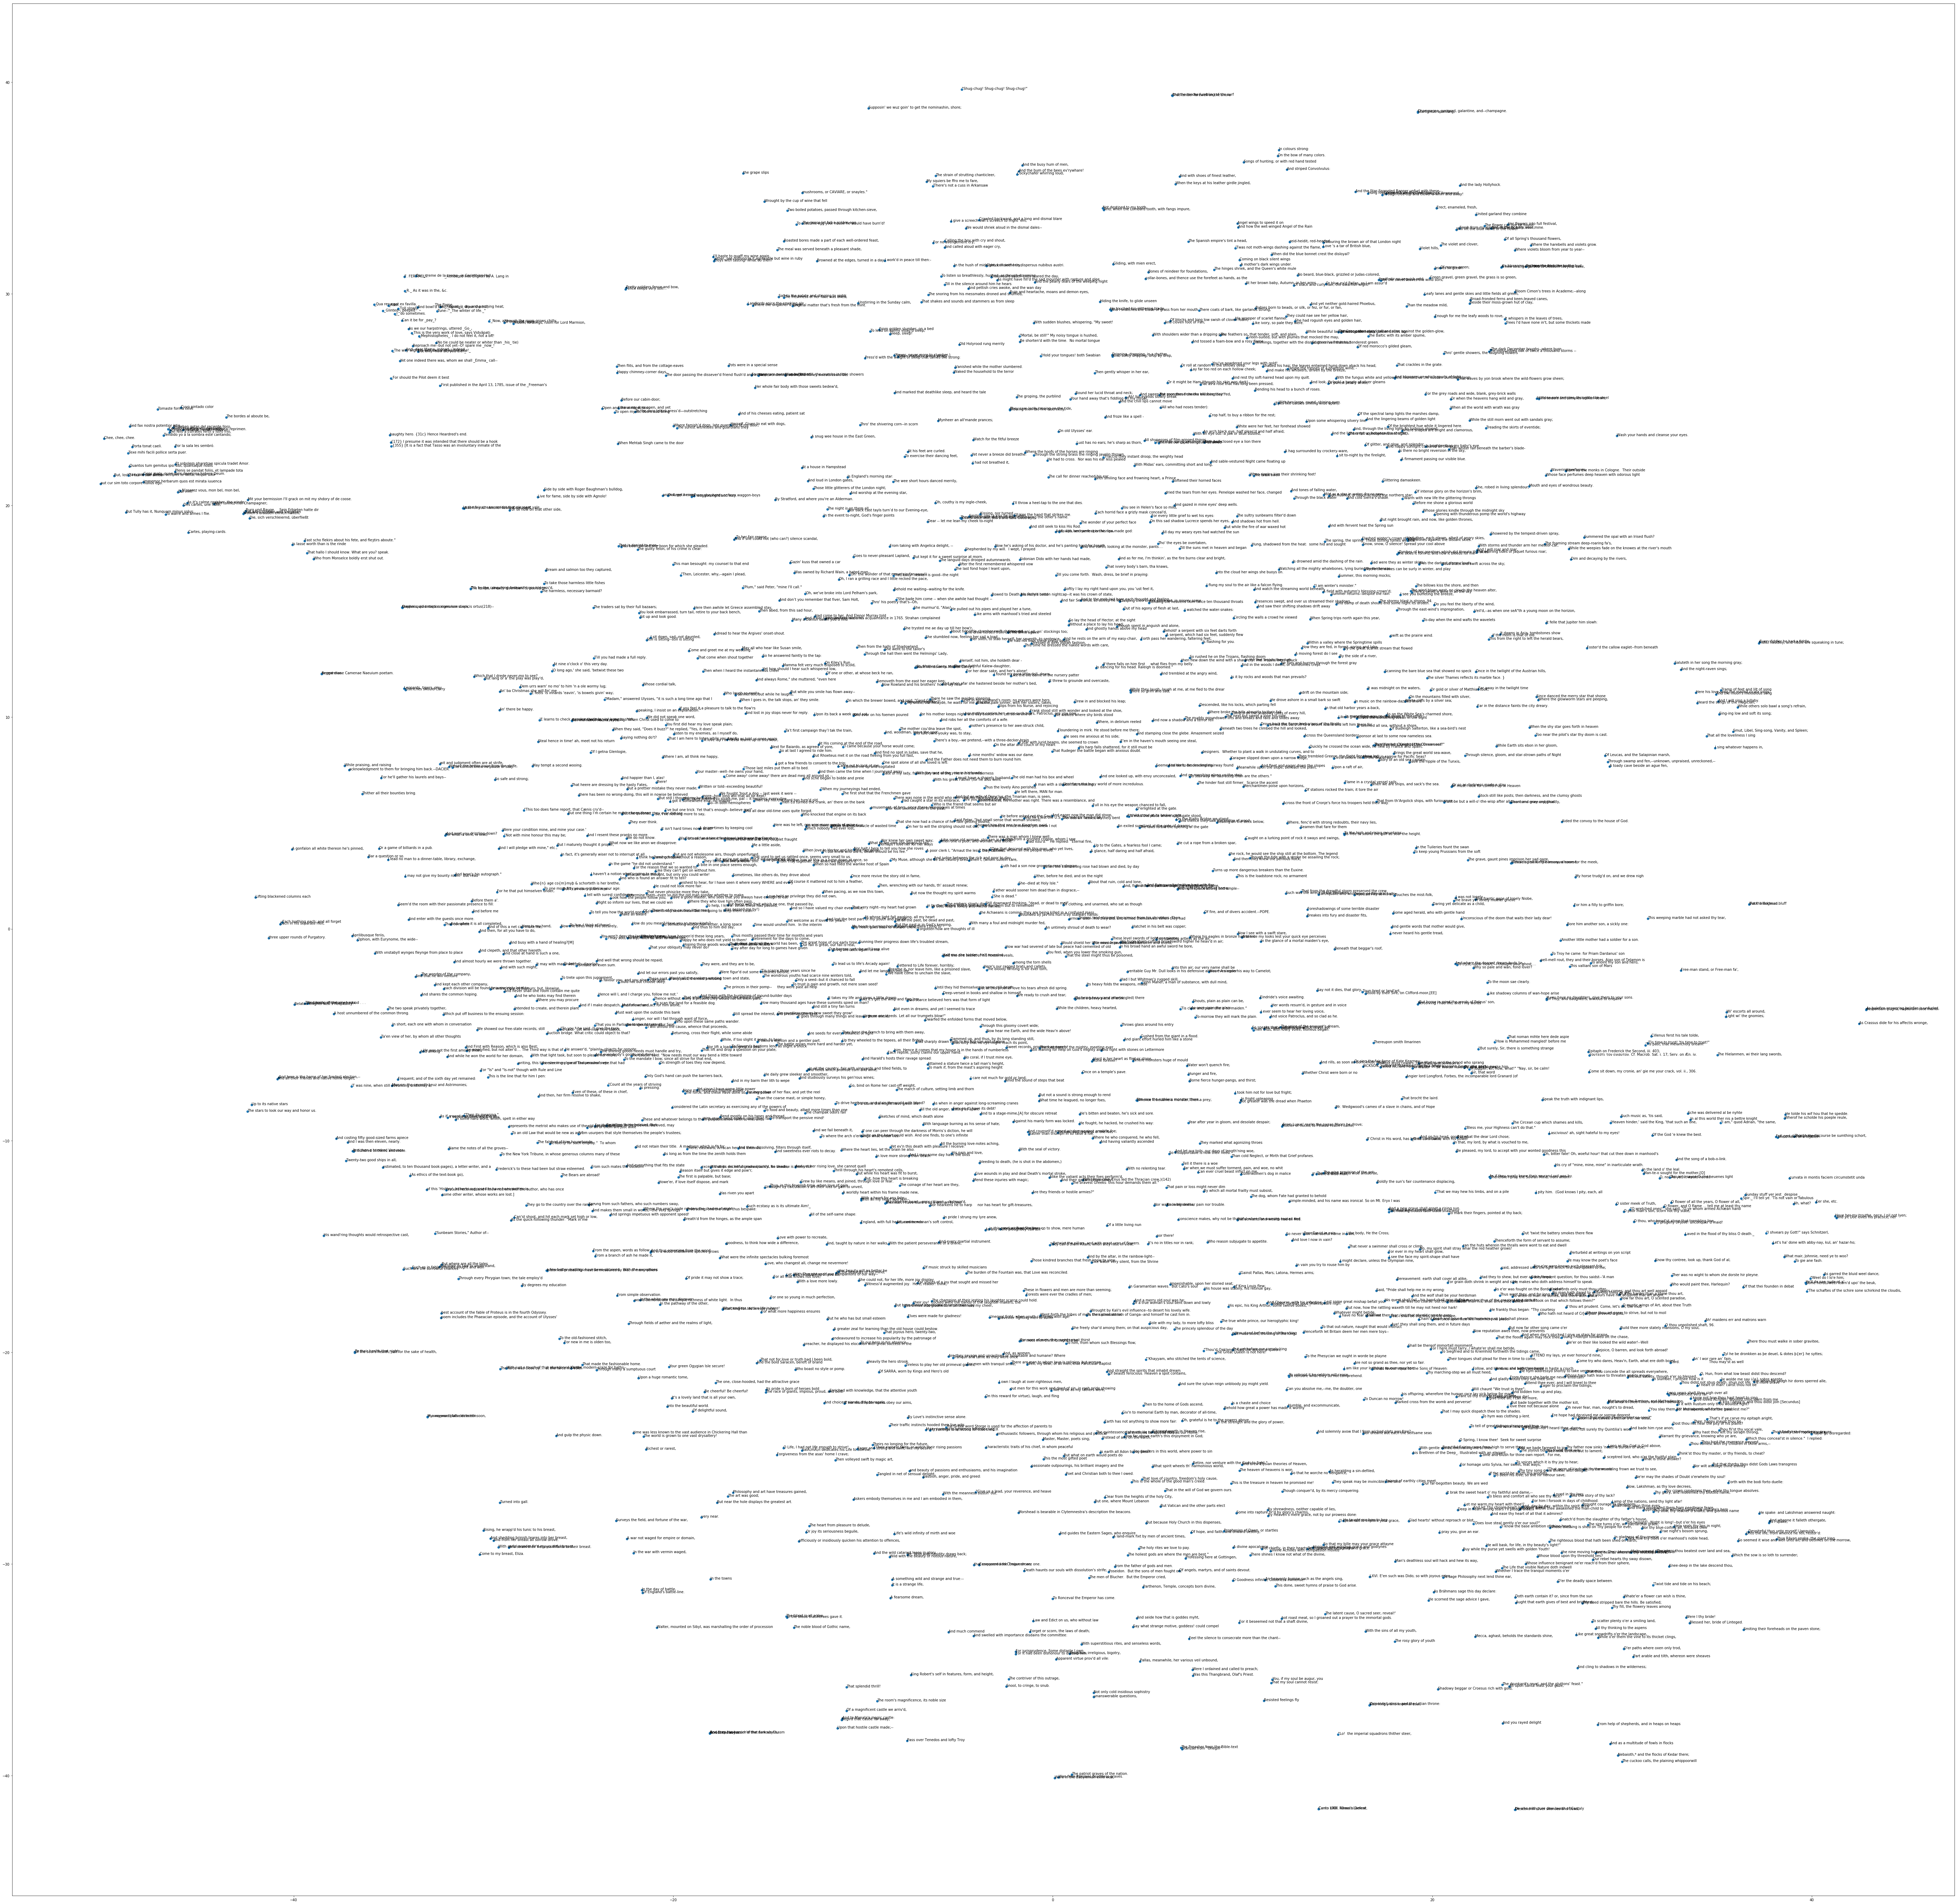

In [39]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(sampled_lines[:2000]):
    plt.annotate(txt, (x[i], y[i]))

### Exporting for google embedding projector

Upload these files [here](https://projector.tensorflow.org/).

In [43]:
with open("emb-proj-vecs.tsv", "w") as fh:
    for vec in inv_embeddings[:2000]:
        fh.write("\t".join(["%0.5f" % val for val in vec]))
        fh.write("\n")

In [44]:
with open("emb-proj-labels.tsv", "w") as fh:
    fh.write("\n".join(sampled_lines[:2000]))

## Finding clusters

In the visualization above, you may have seen some evidence of "clustering"—groups of items that seem to be related. There are algorithms that facilitate finding such clusters *automatically*. This can be an interesting and valuable way to explore your data—you might find clusters of meaning that you didn't expect.

We're going to use the [K-Means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering) (in particular, scikit-learn's [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

In [40]:
cluster_count = 25 # adjust this until it starts giving you good results!

In [41]:
from sklearn.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=cluster_count)
clusters = clusterer.fit_predict(inv_embeddings)

In [42]:
from collections import defaultdict
group_by_cluster = defaultdict(list)

In [43]:
for i, item in enumerate(clusters):
    group_by_cluster[item].append(sampled_lines[i])

In [44]:
for i in range(cluster_count):
    print(f"Cluster {i} ({len(group_by_cluster[i])} items)")
    print("Closest to center: ", inv_nn.nearest(clusterer.cluster_centers_[i], 1)[0])
    print()
    print("\n".join(random.sample(group_by_cluster[i],
                  min(8, len(group_by_cluster[i])))))
    print("\n---")

Cluster 0 (418 items)
Closest to center:  Lay far too red on each hollow cheek;

But on the sword he gazed elate
--Ah! his eyelids slowly break
Crushed as a wind-swept bed of reeds is bowed,
And, softly dripping, drop by drop,
Wring their necks and hurl their bodies
The duck is truss'd from head to heels,
Like arms with manhood’s tried and steeled
And still, in the lightnings, coldly glitter

---
Cluster 1 (827 items)
Closest to center:  As having gone from being the earth's friend,

Four motives possible therefor I reach--
His fame, his air as _Marchis_ grand, his beard
Ist like grown folks _shouldn't_ do!
Absurd,--or insincere."
character, and Aubrey (LIVES OF EMINENT MEN, ii. 483) pays him
To learn in Harvard Square.
Bespoke a vinous irritant that amplified my head,
Avise him every man tofore,

---
Cluster 2 (637 items)
Closest to center:  Lay far too red on each hollow cheek;

And drooping rich the dewy head,
You've powdered your legs with gold!
Green-suited, but with plumes that m

## Classifying texts

Sentence vectors make it easy to classify texts—i.e., based on an existing labelled corpus, predict what category some new text will fall into. Let's build a simple classifier that tries to determine whether a given stretch of text is more like a line of poetry or more like a sentence from a recipe book. First, download the plaintext version of [this book](http://www.gutenberg.org/ebooks/26209) and put it in the same directory as this notebook. (You might go in and remove the Gutenberg boilerplate, but you don't have to.)

The following cell parses this text into sentences:

In [45]:
recipe_sents = [sent.text.strip() for sent in nlp(open("./pg26209.txt").read().replace("\n", " "),
                                          disable=['tagger', 'ner']).sents]

In [46]:
len(recipe_sents)

3144

In [48]:
random.sample(recipe_sents, 10)

['RAW JERUSALEM ARTICHOKES AND LETTUCE SALAD.',
 'CELERY SANDWICHES.',
 'Information about Donations to the Project Gutenberg Literary Archive Foundation  Project',
 'To every seven pounds of fruit take five pounds of granulated sugar, a pint of vinegar, two tablespoonfuls of cinnamon and one tablespoonful of cloves, tie the spices up in a muslin bag, add a few pieces of stick cinnamon and a few allspice.',
 '2.695 | 80.385 ---------------------+-------------+-----------------+---------+--------',
 "Poor Man's Cake (a Norwegian recipe)",
 'DATE BREAD.',
 'Set away to dry.',
 'Let it cook until clear, add the sugar and salt, and then the strawberry juice, and boil until thick--a few minutes only; turn into an earthenware mould; when cold set on the ice.',
 'FILLING.--']

We'll pick exactly as many lines from our poetry corpus as the number of sentences we found in the recipe book. (This is cheating a little bit, since most machine learning classification algorithms work best with "balanced classes.")

In [49]:
classify_poem_lines = random.sample(lines, len(recipe_sents))

A classifier tries to predict a category *y* based on some data *X*. The machine learning algorithm is essentially trying to approximate a function *y = f(X)* that most accurately gives the corresponding labels *y* for each value in *X*. Our *X* is going to be the sentence vector for each sentence, and our *y* is going to be 0 for poetry, 1 for recipe. (Category labels should always be integers; starting with 0 and counting up is best.)

In [50]:
X = [] # embeddings of lines
y = [] # categories of lines
all_text = [] # actual text

In [51]:
for text in classify_poem_lines:
    all_text.append(text)
    X.append(summary_inv_freq(text))
    y.append(0) # 0 for poem
for text in recipe_sents:
    all_text.append(text)
    X.append(summary_inv_freq(text))
    y.append(1) # 1 for recipes

Validate that our categories are even:

In [53]:
from collections import Counter
Counter(y).most_common()

[(0, 3144), (1, 3144)]

Any classifier has a 50% chance of getting any guess correct. So for our classifier to be any good, it has to be able to predict with a greater than 50% chance.

### Train/test split

We'll train the model with some of our data, and set aside some of the data for testing the model. It's important to set aside testing data as a way to validate that the model is accurate on data that it has never seen. The `train_test_split()` function in scikit-learn is a very easy way to do this. It first shuffles the data, and then partitions it into two parts: training data (75%) and testing data (25%).

In [55]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(np.array(X), np.array(y), all_text)

In [59]:
len(X_train), len(y_train), len(labels_train), len(X_test), len(y_test), len(labels_test)

(4716, 4716, 4716, 1572, 1572, 1572)

Now, we're training the classifier. We won't go into the details of how the classifier works! You could drop in any other classifier, really, including a neural network. But the Random Forest Classifier works just fine and is surprisingly fast.

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
rfc = RandomForestClassifier(n_estimators=200, class_weight="balanced", verbose=1, n_jobs=-1)

In [62]:
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)

Now, we'll see how accurate the model is by *predicting* the categories in the test set.

In [65]:
preds = rfc.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [66]:
from sklearn import metrics

The accuracy score is simply a percentage of how many predictions were correct:

In [67]:
metrics.accuracy_score(y_test, preds)

0.9573791348600509

But there are other useful measures of how good the model is at classifying things:

In [68]:
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       813
           1       0.98      0.94      0.95       759

   micro avg       0.96      0.96      0.96      1572
   macro avg       0.96      0.96      0.96      1572
weighted avg       0.96      0.96      0.96      1572



* precision = of items labeled X, how many were actually X?
* recall = of all items that were actually X, how many were labeled X?
* f1 score: weighted average of the two.

Let's try classifying individual, randomly-selected items. (Remember, 0 is poem, 1 is recipe.)

In [79]:
rand_idx = random.randrange(len(X_test))
print(rfc.predict([X_test[rand_idx]]), text_test[rand_idx])

[1] Serve with cream or soft boiled custard.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished


The `.predict_proba()` method gives us the *probability* of each category, rather than just the category. The first item in the square brackets is the probability of category 0 (i.e., poem), and the second item is the probability of category 1 (i.e., recipe). The larger the number, the more probable the text belongs to that category (according to the classifier).

In [83]:
rand_idx = random.randrange(len(X_test))
print(rfc.predict_proba([X_test[rand_idx]]), text_test[rand_idx])

[[0.745 0.255]] When we get to some spot wheer it's dry."


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


Predicting everything in the test set along with probabilities:

In [84]:
preds_with_prob = rfc.predict_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In the test set, here are the items deemed most likely to be poetry, along with their predicted probabilities and true category:

In [85]:
for idx in np.argsort(preds_with_prob[:,0])[-10:]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

When thy loving mother brought thee [0.995 0.005] 0
To bring thee twilight. Still, ah! still the hum [0.995 0.005] 0
My gladness keepeth me concealed from thee, [0.995 0.005] 0
Yon sister that sang o'er his saftly-rock'd bed [1. 0.] 0
I said: "What sayeth this, and what respondeth [1. 0.] 0
him right away.  So he seen a comrade a-chargin', [1. 0.] 0
And we bade farewell to joy; [1. 0.] 0
Rahéro saw him go by, and the heart of Rahéro was glad, [1. 0.] 0
As doth a high-born lady / when that she did perceive, [1. 0.] 0
What seekest thou? [1. 0.] 0


Likewise, those deemed most likely to be from the recipe book:

In [86]:
for idx in np.argsort(preds_with_prob[:,0])[:10]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

Half a pound of granulated sugar, half a pound of strained honey, half a pound of candied orange peel, half a pound of citron, half a pound of almonds blanched and cut fine, an even teaspoonful of bicarbonate of potash pounded very fine and a sherry glass of rum poured over it twenty-four hours before it is used, an even teaspoonful of cloves, an even teaspoonful of cinnamon, an even teaspoonful of powdered cardamom seed, the rind of half a lemon grated, and two eggs. [0. 1.] 1
* [0. 1.] 1
Drain the beans and turn them into the spider, add a cup of boiling water and stir until the water becomes thick like cream. [0. 1.] 1
Beat the eggs light, add to them the milk, sugar and salt, and pour over the rice and fruit and bake from twenty-five to thirty minutes. [0. 1.] 1
Twelve eggs, the weight of ten in powdered sugar, the weight of six in sifted flour, the grated rind and juice of one lemon. [0. 1.] 1
Boil twelve eggs hard, shell and cut them in slices and lay them in a deep dish in close

The most ambiguous items (i.e., the items whose probabilities are closest to 50% for each category):

In [88]:
diffs = np.abs(preds_with_prob[:,0] - preds_with_prob[:,1])

In [89]:
for idx in np.argsort(diffs)[:20]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

Mix all well together, form into an oblong shape, leaving the top rough. [0.505 0.495] 1
FRIJOLES FRITOS. [0.50544396 0.49455604] 1
Yielded to laws and strictest codes. For since [0.51 0.49] 0
POLISH FOR HARD [0.515 0.485] 1
In 2001, the Project Gutenberg Literary Archive Foundation was created to provide a secure and permanent future for Project Gutenberg-tm and future generations. [0.485 0.515] 1
"     " [0.48215226 0.51784774] 1
She is the Bitter-apple of my life, [0.48 0.52] 0
Do not let them remain in the water. [0.48 0.52] 1
And cast to chance the bitter seed [0.52031928 0.47968072] 0
THE                                 GOLDEN AGE                                 COOK BOOK. [0.475 0.525] 1
Then set it away on ice. [0.525 0.475] 1
The copyright laws of the place where you are located also govern what you can do with this work. [0.52536481 0.47463519] 1
Turn it out, let it cool, and then form into cylinders and fry as usual. [0.53 0.47] 1
RAISED FINGER-ROLLS. [0.465 0.535] 1
This eB

Finally, lines of poetry deemed to be recipe-like:

In [90]:
recipelike = []
for idx in np.argsort(preds_with_prob[:,0]):
    if y_test[idx] == 0:
        recipelike.append((text_test[idx], preds_with_prob[idx]))
for item, score in recipelike[:12]:
    print(item, score)

And warm sweet milk in bowls of brass: [0.05 0.95]
If plums grew on a thistle; [0.13 0.87]
Of fragrant apples, blushing plums, or pears; [0.16609083 0.83390917]
Not such weight of pots and kettles, [0.275 0.725]
Condemned to milk and water! [0.295 0.705]
Warm and smoky Indian summer [0.3 0.7]
And again the sturgeon, Nahma, [0.31572842 0.68427158]
Now once again with eager zest [0.345 0.655]
To swim and drown in, the pink clover mead [0.38 0.62]
Their treasures, offering incense, myrrh, and gold. [0.39 0.61]
White with foamy falls; [0.395 0.605]
Should have a hook, and a small trout to pull it. [0.4 0.6]


And poem-like recipe sentences:

In [91]:
poemlike = []
for idx in np.argsort(preds_with_prob[:,1]):
    if y_test[idx] == 1:
        poemlike.append((text_test[idx], preds_with_prob[idx]))
for item, score in poemlike[:12]:
    print(item, score)

Then let our countenances be looked upon before thee, and the countenance of the children that eat of the portion of the king's meat: and as thou seest, deal with thy servants. [0.98 0.02]
Their eloquent silence should not ask our sympathy and aid in vain; they have a right, as our humble brothers, to our loving care and protection, and to demand justice and pity at our hands; and, as a part of the One Life, to--      "life, which all can take but none can give;      Life, which all creatures love and strive to keep; [0.98 0.02]
For that which befalleth the sons of men befalleth beasts; even one thing befalleth them: as the one dieth, so dieth the other; yea, they have all one breath; so that a man hath no preeminence above a beast: for all is vanity. [0.975 0.025]
I send this little book out into the world, first, to aid those who, having decided to adopt a bloodless diet, are still asking how they can be nourished without flesh; second, in the hope of gaining something further to pro